<a href="https://colab.research.google.com/github/philipp-lampert/mymandible/blob/main/data_science/03_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Feature engineering
This notebook handles feature engineering and encodes categorical variables numerically for models that cannot handle categorical variables natively.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

In [2]:
df = pd.read_parquet('https://github.com/philipp-lampert/mymandible/blob/main/data_science/data/pipeline/02_preprocessed.parquet?raw=true')

As a first step we will remove all columns that contain data only meant for descriptive purposes but that are not useful as predictors. In addition, these variables are conditional, meaning they are not applicable to all rows which leads to a lot of missing data inside these columns that cannot be imputed.

In [3]:
date_columns = [column for column in df.columns if column.startswith("days_to_")]
date_columns.remove('days_to_follow_up')
other_columns = ['which_autoimmune_disease', 'which_bleeding_disorder', 'long_plate_thickness', 'mini_plate_thickness', 'tmj_replacement_type']
remove_columns = date_columns + other_columns

df = df.drop(columns=remove_columns)

We first create a list of all predictor variables, as we will only remove variables that are predictors.

In [4]:
first_outcome_var = df.columns.get_loc('flap_revision')
predictors = df.columns[:first_outcome_var].tolist()

We will now remove all boolean variables that have a prevalence of less than 5% of either level as low-prevalence variables can lead to overfitting.

In [5]:
bool_predictors = df[predictors].select_dtypes('boolean').columns.values
prevalence = df[bool_predictors].mean(numeric_only=True)
low_prevalence_columns = prevalence[prevalence < 0.05].index.tolist()
low_prevalence_columns

['comorbidity___osteoporosis', 'comorbidity___bleeding_disorder']

As we can see, only two non-categorical variables are affected. Both bleeding disorder and osteoporosis occured very rarely. There are now two options to deal with the variables:


1.   We can create a new level for all other comorbidities.
2.   We can check if these patients had any other comorbidity. If yes, we can simply delete the two variables in question, if not, we will assign these patients to `comorbidity___none`.

While the first approach might seem more intuitive, we chose to go with the second approach. This is mainly for two reasons: First, a newly created level for other comorbidities will still have a very low prevalence since it is made up of only two variables. Second, "other comorbidity" is a very broad term and technically it would mean "had bleeding disorder or osteoporosis" which does not make sense to be grouped together.

In [6]:
comorbidity_columns = [col for col in df.columns if col.startswith("comorbidity___")]
other_comorbidity_columns = [x for x in comorbidity_columns if x not in low_prevalence_columns]

print(df['comorbidity___none'].value_counts())

lpc_mask = df[low_prevalence_columns].any(axis=1)
occ_mask = df[other_comorbidity_columns].any(axis=1)
df.loc[lpc_mask & ~occ_mask, 'comorbidity___none'] = True
df = df.drop(low_prevalence_columns, axis=1)

print(df['comorbidity___none'].value_counts())

False    137
True      39
Name: comorbidity___none, dtype: Int64
False    136
True      40
Name: comorbidity___none, dtype: Int64


Let's now do the same for very high prevalence columns > 95%.

In [7]:
high_prevalence_columns = prevalence[prevalence > 0.95].index.tolist()
high_prevalence_columns

['urkens_classification___b']

In [8]:
df = df.drop(high_prevalence_columns, axis=1)

Next, we will examine the categorical variables and check which have levels with a prevalence of less than 5%.

In [9]:
first_outcome_var = df.columns.get_loc('flap_revision')
predictors = df.columns[:first_outcome_var].tolist() #Update predictor list

categorical_columns = df[predictors].select_dtypes('category').columns.tolist()
low_prevalence_levels =[]

for column in categorical_columns:
    level_percentages = df[column].value_counts(normalize=True)
    if any(level_percentages < 0.05):
        low_prevalence_levels.append(column)

low_prevalence_levels

['indication', 'plate_type', 'flap_segment_count']

In [10]:
df['indication'].value_counts(normalize=True)

malignant_tumor                     0.630682
osteoradionecrosis                  0.176136
flap_loss                           0.056818
benign_tumor                        0.039773
medication_related_osteonecrosis    0.034091
secondary_reconstruction            0.034091
osteomyelitis                       0.022727
trauma                              0.005682
Name: indication, dtype: float64

We could simply replace all levels below 5% with other, but grouping indications that are related in their pathophysiology is certainly better.

Osteomyelitis is such a rare and different indication that we decided to completely drop patients with that indication from our dataset.

In [11]:
df = df[df['indication'] != 'osteomyelitis']

tumor = ['malignant_tumor', 'benign_tumor']
necrosis = ['medication_related_osteonecrosis', 'osteoradionecrosis']
secondary_reconstruction = ['trauma', 'secondary_reconstruction', 'flap_loss']

conditions = [
    df['indication'].isin(tumor),
    df['indication'].isin(necrosis),
    df['indication'].isin(secondary_reconstruction)
]

values = ['tumor', 'necrosis', 'secondary_reconstruction']

# Apply np.select to create the new column
df['indication'] = np.select(conditions, values, default=df['indication'])
df['indication'] = df['indication'].astype('category')

This way we replaced the very low prevalence columns with groups.

In [12]:
first_outcome_var = df.columns.get_loc('flap_revision')
predictors = df.columns[:first_outcome_var].tolist()

In [13]:
df['flap_segment_count'].value_counts(normalize=True)

two      0.517442
three    0.273256
one      0.203488
four     0.005814
Name: flap_segment_count, dtype: float64

##Encoding
In this variable can solve the issue of low-prevalence without actually removing the 4th level by using Label Encoding since `flap_segment_count` is an ordinal categorical variable. This preserves the order of our variable and since it becomes a numeric variable having rare outliers is not as much of an issue anymore.

In [14]:
label_mapping = {'one': 1, 'two': 2, 'three': 3, 'four': 4}

df['flap_segment_count'] = df['flap_segment_count'].map(label_mapping).astype('UInt8')

Let's now check if ther are any high prevalence levels within categorical columns > 95%.

In [15]:
first_outcome_var = df.columns.get_loc('flap_revision')
predictors = df.columns[:first_outcome_var].tolist() #Update predictor list

categorical_columns = df[predictors].select_dtypes('category').columns.tolist()
high_prevalence_levels =[]

for column in categorical_columns:
    level_percentages = df[column].value_counts(normalize=True)
    if any(level_percentages > 0.95):
        high_prevalence_levels.append(column)

high_prevalence_levels

[]

There are no categorical levels with a prevalence > 95%.

##Collinearity
We now have to encode all remaining categorical variables to numeric/binary variables as most models can handle categorical data and handle collinearity.

In [17]:
df = df.drop(['weight_kg', 'height_cm'], axis = 1)

first_outcome_var = df.columns.get_loc('flap_revision')
predictors = df.columns[:first_outcome_var].tolist()
outcomes = df.columns[first_outcome_var:].tolist()
df_outcomes = df[outcomes]

df_encoded_all_levels = pd.get_dummies(df[predictors], columns=categorical_columns, drop_first=False)
df_encoded_all_levels = df_encoded_all_levels.join(df_outcomes)

df_encoded_dropped_first = pd.get_dummies(df[predictors], columns=categorical_columns, drop_first=True)
df_encoded_dropped_first = df_encoded_dropped_first.join(df_outcomes)

first_outcome_var = df_encoded_dropped_first.columns.get_loc('flap_revision')
predictors = df_encoded_dropped_first.columns[:first_outcome_var].tolist()
first_level = df_encoded_dropped_first[predictors].filter(like='___none').columns.tolist()
df_encoded_dropped_first = df_encoded_dropped_first.drop(first_level, axis=1)

In [18]:
first_outcome_var = df_encoded_dropped_first.columns.get_loc('flap_revision')
predictors = df_encoded_dropped_first.columns[:first_outcome_var].tolist()

<Axes: >

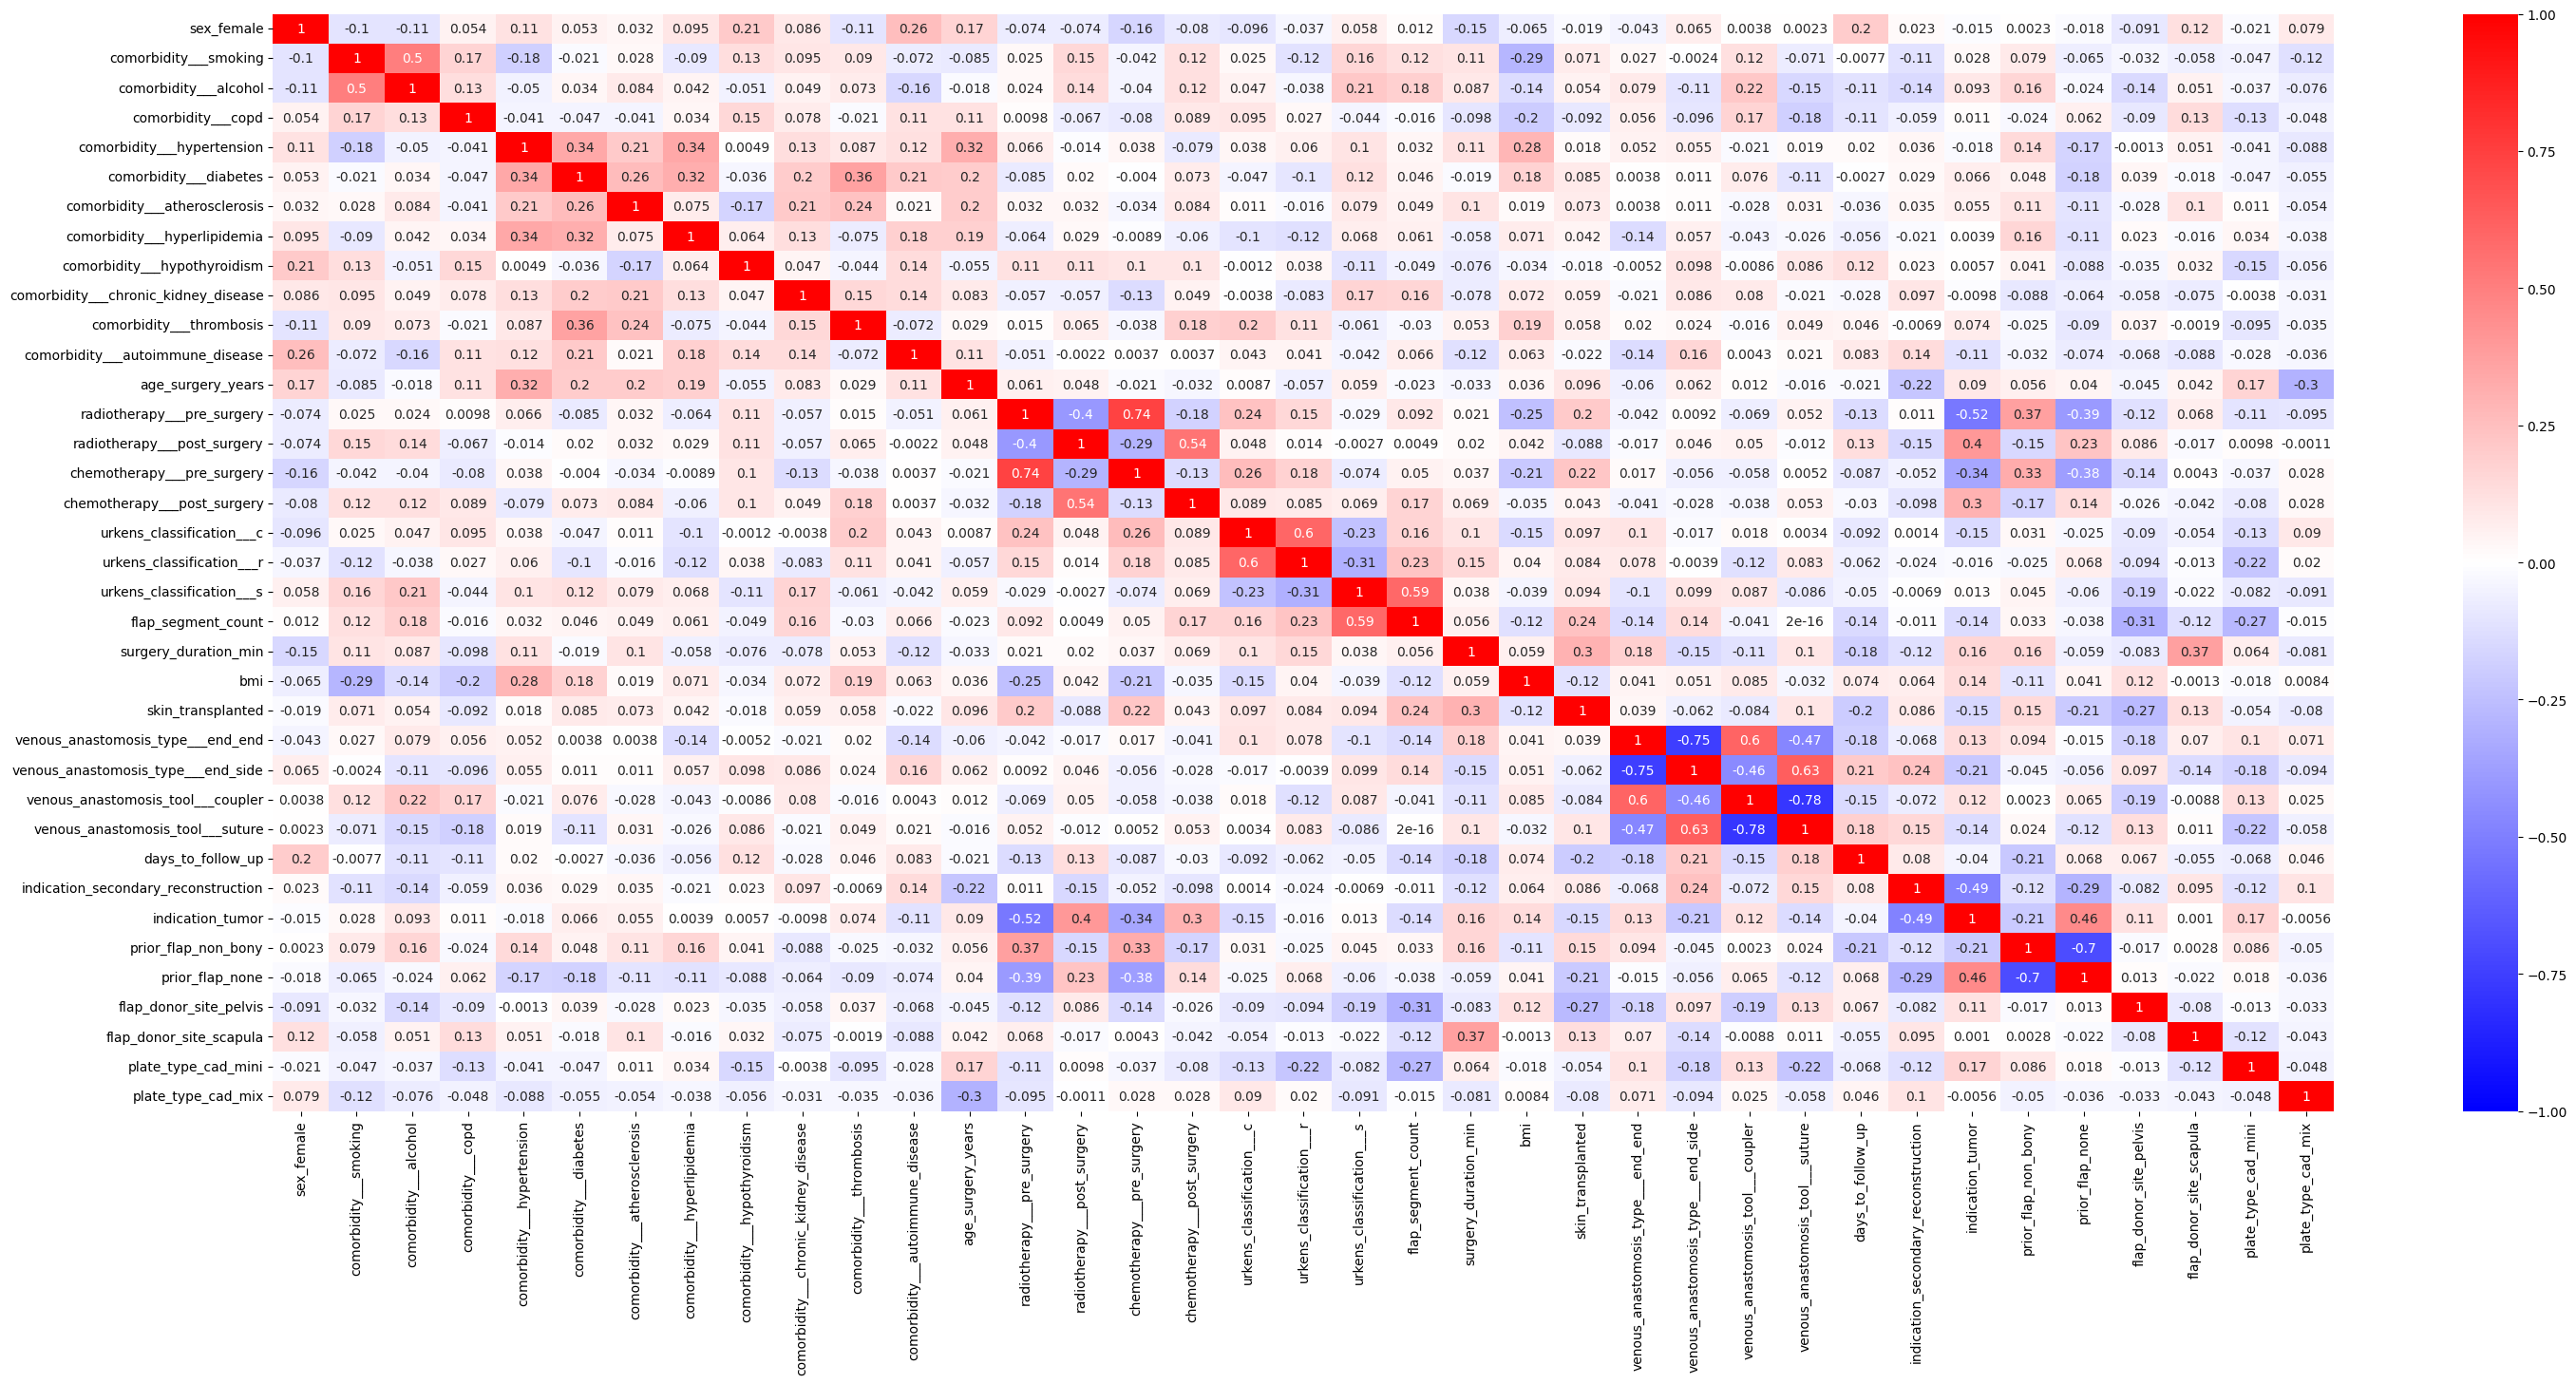

In [19]:
corr = df_encoded_dropped_first[predictors].corr(numeric_only=False)
fig, ax = plt.subplots()
fig.set_size_inches(35, 15)
sns.heatmap(corr, annot=True, cmap="bwr", center=0, vmin=-1, vmax=1, ax=ax)

A correlation is generally considered strong when the r-value is > 0.9. Fortunately, this is not the case for any pair among the variables.

##Exporting data frames
We will now save different data frames each handling categorical data differently. This is because some models can handle categorical data natively without encoding while others require all data to be in a numeric format.

In [20]:
df_encoded_dropped_first.to_parquet('03_encoded_dropped_first.parquet')
df_encoded_all_levels.to_parquet('03_encoded_all_levels.parquet')